# Import data

In [1]:
%matplotlib inline

import glob
import os
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
from keras.models import Model
from keras import applications
from keras.utils.np_utils import to_categorical 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Dimensions of our images.
img_width, img_height = 240, 240

# epochs and batch_size
epochs = 100
batch_size = 32

# path to train and validation data
train_data_dir = 'data/train_sample'
valid_data_dir = 'data/valid_sample'
# train_data_dir = '/dev/shm/train'
# valid_data_dir = '/dev/shm/valid'

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 4911 images belonging to 46 classes.


In [6]:
valid_generator = datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 1690 images belonging to 46 classes.


In [7]:
n_classes = 46
train_samples = 4911
valid_samples = 1690
# n_classes = 6451
# train_samples = 859486
# valid_samples = 294058

# Basic CNN

In [8]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 238, 238, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 117, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 117, 117, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
__________

In [10]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/basic_cnn.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
 - 30s - loss: 3.0181 - acc: 0.2099 - val_loss: 2.3936 - val_acc: 0.3988

Epoch 00001: val_acc improved from -inf to 0.39882, saving model to models/basic_cnn.h5
Epoch 2/100
 - 27s - loss: 2.0884 - acc: 0.4891 - val_loss: 1.7015 - val_acc: 0.6012

Epoch 00002: val_acc improved from 0.39882 to 0.60118, saving model to models/basic_cnn.h5
Epoch 3/100
 - 28s - loss: 1.5654 - acc: 0.6132 - val_loss: 1.4887 - val_acc: 0.6479

Epoch 00003: val_acc improved from 0.60118 to 0.64793, saving model to models/basic_cnn.h5
Epoch 4/100
 - 27s - loss: 1.2291 - acc: 0.6910 - val_loss: 1.7295 - val_acc: 0.6314

Epoch 00004: val_acc did not improve from 0.64793
Epoch 5/100
 - 27s - loss: 1.0115 - acc: 0.7393 - val_loss: 1.0428 - val_acc: 0.7414

Epoch 00005: val_acc improved from 0.64793 to 0.74142, saving model to models/basic_cnn.h5
Epoch 6/100
 - 28s - loss: 0.7924 - acc: 0.7916 - val_loss: 1.3722 - val_acc: 0.6621

Epoch 00006: val_acc did not improve from 0.74142
Epoch 7/100
 - 29s - lo

In [11]:
model.evaluate_generator(valid_generator, valid_samples)

[1.537684826692606, 0.7904961590254271]

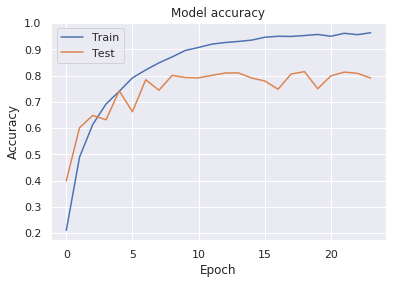

In [12]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Data Augumentation

In [13]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1. / 255,      
        shear_range=0.2,       
        zoom_range=0.2,        
        horizontal_flip=True)  

In [14]:
train_generator = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 4911 images belonging to 46 classes.


In [15]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/data_augmentation.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
 - 49s - loss: 1.0320 - acc: 0.7609 - val_loss: 0.8733 - val_acc: 0.8089

Epoch 00001: val_acc improved from -inf to 0.80888, saving model to models/data_augmentation.h5
Epoch 2/100
 - 47s - loss: 0.8235 - acc: 0.7937 - val_loss: 0.8055 - val_acc: 0.8107

Epoch 00002: val_acc improved from 0.80888 to 0.81065, saving model to models/data_augmentation.h5
Epoch 3/100
 - 47s - loss: 0.7418 - acc: 0.8090 - val_loss: 1.0518 - val_acc: 0.7882

Epoch 00003: val_acc did not improve from 0.81065
Epoch 4/100
 - 46s - loss: 0.7063 - acc: 0.8303 - val_loss: 0.8213 - val_acc: 0.8107

Epoch 00004: val_acc did not improve from 0.81065
Epoch 5/100
 - 47s - loss: 0.6704 - acc: 0.8254 - val_loss: 0.8138 - val_acc: 0.8124

Epoch 00005: val_acc improved from 0.81065 to 0.81243, saving model to models/data_augmentation.h5
Epoch 6/100
 - 46s - loss: 0.6403 - acc: 0.8315 - val_loss: 0.8842 - val_acc: 0.8189

Epoch 00006: val_acc improved from 0.81243 to 0.81893, saving model to models/data_augment

In [16]:
model.evaluate_generator(valid_generator, valid_samples)

[0.7307539990180568, 0.825936096676401]

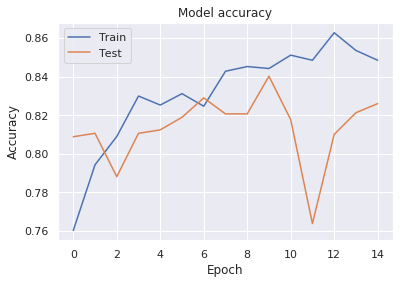

In [17]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# VGG 16 models

In [18]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

In [19]:
bottleneck_features_train = model_vgg.predict_generator(train_generator, np.ceil(train_samples/float(batch_size)))
#np.save(open('/dev/shm/models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [20]:
bottleneck_features_validation = model_vgg.predict_generator(valid_generator, np.ceil(valid_samples/float(batch_size)))
#np.save(open('/dev/shm/models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [21]:
num_classes = len(train_generator.class_indices)

train_data = bottleneck_features_train
train_labels = to_categorical(train_generator.classes[:train_samples], num_classes=num_classes)

validation_data = bottleneck_features_validation
validation_labels = to_categorical(valid_generator.classes[:valid_samples], num_classes=num_classes)

In [22]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(n_classes, activation='softmax'))

model_top.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

In [23]:
model_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 46)                23598     
Total params: 12,869,166
Trainable params: 12,869,166
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/bottleneck_features.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model_top.fit(
        train_data,
        train_labels,
        verbose=2,
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[checkpointer, early_stopping],
        validation_data=(validation_data, validation_labels))

Train on 4911 samples, validate on 1690 samples
Epoch 1/100
 - 5s - loss: 6.3486 - acc: 0.1014 - val_loss: 3.1075 - val_acc: 0.1355

Epoch 00001: val_acc improved from -inf to 0.13550, saving model to models/bottleneck_features.h5
Epoch 2/100
 - 5s - loss: 3.2919 - acc: 0.1228 - val_loss: 3.0974 - val_acc: 0.1373

Epoch 00002: val_acc improved from 0.13550 to 0.13728, saving model to models/bottleneck_features.h5
Epoch 3/100
 - 5s - loss: 3.2068 - acc: 0.1313 - val_loss: 3.1266 - val_acc: 0.1142

Epoch 00003: val_acc did not improve from 0.13728
Epoch 4/100
 - 5s - loss: 3.1888 - acc: 0.1356 - val_loss: 3.2112 - val_acc: 0.1302

Epoch 00004: val_acc did not improve from 0.13728
Epoch 5/100
 - 5s - loss: 3.1525 - acc: 0.1401 - val_loss: 3.1528 - val_acc: 0.1231

Epoch 00005: val_acc did not improve from 0.13728
Epoch 6/100
 - 5s - loss: 3.1239 - acc: 0.1503 - val_loss: 3.1826 - val_acc: 0.1095

Epoch 00006: val_acc did not improve from 0.13728
Epoch 7/100
 - 5s - loss: 3.0766 - acc: 0.1

In [25]:
model_top.evaluate(validation_data, validation_labels)

1690/1690 [==============================] - 0s 140us/step


[3.631106745138676, 0.12011834319526628]

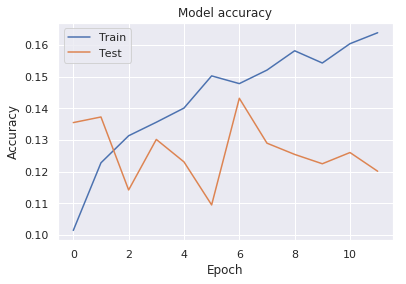

In [26]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Fine Tuning

In [27]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [28]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

top_model.load_weights('models/bottleneck_features.h5')

model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))

In [29]:
for layer in model.layers[:15]:
    layer.trainable = False

In [30]:
# Compile the model with a SGD/momentum optimizer and a slow learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0         
__________

# Training

In [32]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/finetuning_full.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
 - 151s - loss: 2.5924 - acc: 0.3370 - val_loss: 1.9187 - val_acc: 0.5858

Epoch 00001: val_acc improved from -inf to 0.58580, saving model to models/finetuning_full.h5
Epoch 2/100
 - 147s - loss: 1.8005 - acc: 0.5446 - val_loss: 1.4554 - val_acc: 0.6379

Epoch 00002: val_acc improved from 0.58580 to 0.63787, saving model to models/finetuning_full.h5
Epoch 3/100
 - 148s - loss: 1.5035 - acc: 0.6234 - val_loss: 1.2601 - val_acc: 0.6970

Epoch 00003: val_acc improved from 0.63787 to 0.69704, saving model to models/finetuning_full.h5
Epoch 4/100
 - 150s - loss: 1.2983 - acc: 0.6662 - val_loss: 1.1770 - val_acc: 0.6976

Epoch 00004: val_acc improved from 0.69704 to 0.69763, saving model to models/finetuning_full.h5
Epoch 5/100
 - 153s - loss: 1.1643 - acc: 0.7010 - val_loss: 0.9725 - val_acc: 0.7615

Epoch 00005: val_acc improved from 0.69763 to 0.76154, saving model to models/finetuning_full.h5
Epoch 6/100
 - 151s - loss: 1.0247 - acc: 0.7276 - val_loss: 0.8442 - val_acc: 0.78

# Evaluation

In [33]:
model.evaluate_generator(valid_generator, valid_samples)

[0.2300461845531866, 0.9532044382025794]

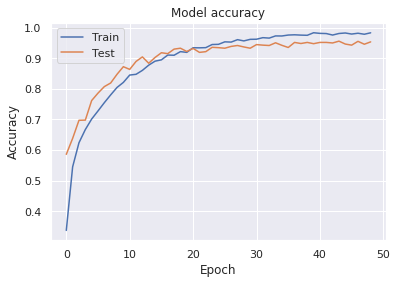

In [34]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()